# Underwater Object Detection with Faster R-CNN

This notebook is a step-by-step tutorial on how to train a Faster R-CNN model for object detection for underwater images. The dataset used in this notebook is the [Underwater Image Dataset](https://www.kaggle.com/datasets/slavkoprytula/aquarium-data-cots). 

## Introduction 
Object detection is a computer vision task that involves both localizing objects in images and classifying them. Faster R-CNN is a popular deep learning model for object detection that is an evolution of the R-CNN and Fast R-CNN models. Faster R-CNN is composed of two modules: a region proposal network (RPN) that generates region proposals and a network that uses these proposals to detect objects. You can learn more about this network [here](https://arxiv.org/abs/1506.01497). The architecture used in this notebook is based on [this paper](https://www.researchgate.net/publication/368708716_Underwater_Object_Detection_Method_Based_on_Improved_Faster_RCNN).

In this notebook we will use some techniques to improve the performance of the model, such as data augmentation, transfer learning, and hyperparameter tuning, OHEM, GIOU loss, and Soft-NMS.

- **Data Augmentation**: Data augmentation is a technique used to artificially increase the size of the training dataset by applying transformations to the images. This technique can help the model generalize better to new data and improve its performance.
- **Transfer Learning**: Transfer learning is a technique that allows you to use a pre-trained model as a starting point for training a new model on a different task. This can help you achieve better performance with less data and computational resources.
- **Hyperparameter Tuning**: Hyperparameter tuning is the process of finding the best set of hyperparameters for a machine learning model. This can help you improve the performance of the model and reduce the risk of overfitting.
- **OHEM**: Online Hard Example Mining (OHEM) is a technique used to focus the training process on the most challenging examples in the dataset. This can help the model learn from its mistakes and improve its performance.
- **GIOU Loss**: Generalized Intersection over Union (GIOU) is a loss function used to measure the similarity between two bounding boxes. This loss function can help the model learn to predict more accurate bounding boxes.
- **Soft-NMS**: Soft Non-Maximum Suppression (Soft-NMS) is a technique used to suppress overlapping bounding boxes by reducing the confidence scores of nearby boxes. This can help the model produce more accurate detections.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
import seaborn as sns
import tqdm
import os
from PIL import Image
import xml.etree.ElementTree as ET

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor, MaskRCNN
from torchvision import transforms
import torchvision.ops as ops

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from collections import Counter
import seaborn as sns
import tqdm
import glob
import os
import json
from PIL import Image
import xml.etree.ElementTree as ET
import pprint
pp = pprint.PrettyPrinter(indent=4)
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
import torchvision.ops as ops
from torch.utils.data import distributed, RandomSampler, SequentialSampler
import random
import cv2

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## EDA (Exploratory Data Analysis)

we will start by loading the dataset and exploring its contents. The dataset contains images of underwater scenes with annotations for the objects present in the images. We will load the images and annotations, visualize some examples, and analyze the distribution of object classes in the dataset.

In [14]:
TRAIN_PATH = "../data/aquarium_pretrain/train"
VAL_PATH = "../data/aquarium_pretrain/valid"
TEST_PATH = "../data/aquarium_pretrain/test"

TRAIN_LABELS = TRAIN_PATH + "/labels"
VAL_LABELS = VAL_PATH + "/labels"
TEST_LABELS = TEST_PATH + "/labels"

TRAIN_IMAGES = TRAIN_PATH + "/images"
VAL_IMAGES = VAL_PATH + "/images"
TEST_IMAGES = TEST_PATH + "/images"

data = "../data/aquarium_pretrain/data.yaml"

In [15]:
classes = ["fish", "jellyfish", "penguin", "puffin", "shark", "starfish", "stingray"]
Idx2Label = {idx: label for idx, label in enumerate(classes)}
Label2Index = {label: idx for idx, label in Idx2Label.items()}
print("Index to Label Mapping:", Idx2Label)
print("Label to Index Mapping:", Label2Index)

Index to Label Mapping: {0: 'fish', 1: 'jellyfish', 2: 'penguin', 3: 'puffin', 4: 'shark', 5: 'starfish', 6: 'stingray'}
Label to Index Mapping: {'fish': 0, 'jellyfish': 1, 'penguin': 2, 'puffin': 3, 'shark': 4, 'starfish': 5, 'stingray': 6}


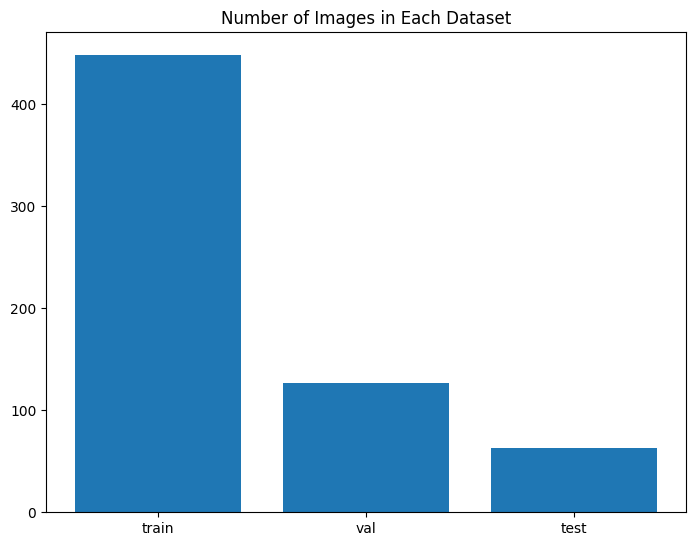

In [16]:
def plot_num_images(data, title):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(data.keys(), data.values())
    plt.title(title)
    plt.show()
    
def get_num_images(path):
    return len(os.listdir(path))

plot_num_images({ "train": get_num_images(TRAIN_IMAGES), "val": get_num_images(VAL_IMAGES), "test": get_num_images(TEST_IMAGES) }, "Number of Images in Each Dataset")

In [17]:
def count_objects_per_images(image_dir, label_dir, object_count, total_object_count):
    image_files = sorted(os.listdir(image_dir))
    for image_file in tqdm.tqdm(image_files):
        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        total_object_count.append(len(lines))
        for line in lines:
            object_count[Idx2Label[int(line.split()[0])]] = object_count.get(Idx2Label[int(line.split()[0])], 0) + 1
        f.close()
        
train_object_count = {}
val_object_count = {}
test_object_count = {}

total_object_per_train_count = []
total_object_per_val_count = []
total_object_per_test_count = []

count_objects_per_images(TRAIN_IMAGES, TRAIN_LABELS, train_object_count, total_object_per_train_count)
count_objects_per_images(VAL_IMAGES, VAL_LABELS, val_object_count, total_object_per_val_count)
count_objects_per_images(TEST_IMAGES, TEST_LABELS, test_object_count, total_object_per_test_count)

100%|██████████| 63/63 [00:00<00:00, 12302.30it/s]


In [18]:
pp.pprint(train_object_count)
print()
pp.pprint(val_object_count)
print()
pp.pprint(test_object_count)

{   'fish': 1961,
    'jellyfish': 385,
    'penguin': 330,
    'puffin': 175,
    'shark': 259,
    'starfish': 78,
    'stingray': 136}

{   'fish': 459,
    'jellyfish': 155,
    'penguin': 104,
    'puffin': 74,
    'shark': 57,
    'starfish': 27,
    'stingray': 33}

{   'fish': 249,
    'jellyfish': 154,
    'penguin': 82,
    'puffin': 35,
    'shark': 38,
    'starfish': 11,
    'stingray': 15}


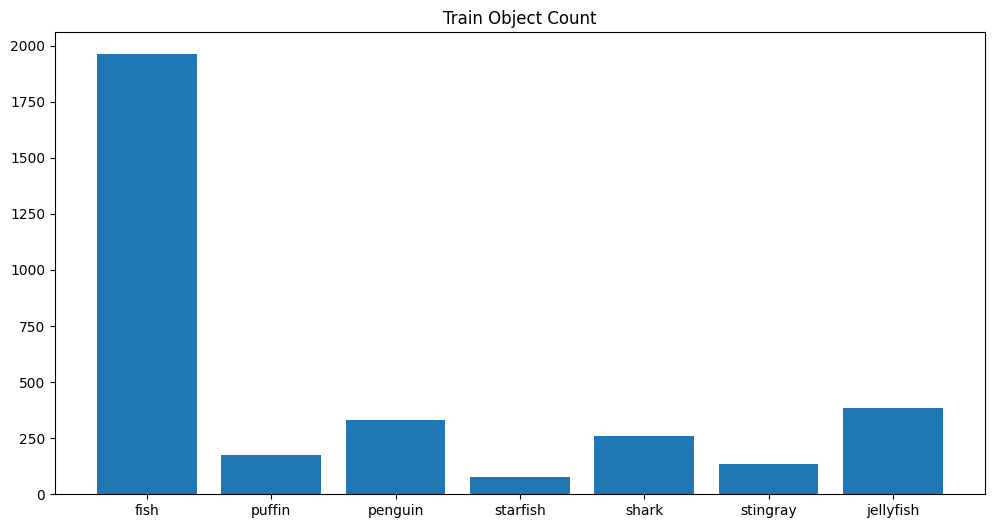

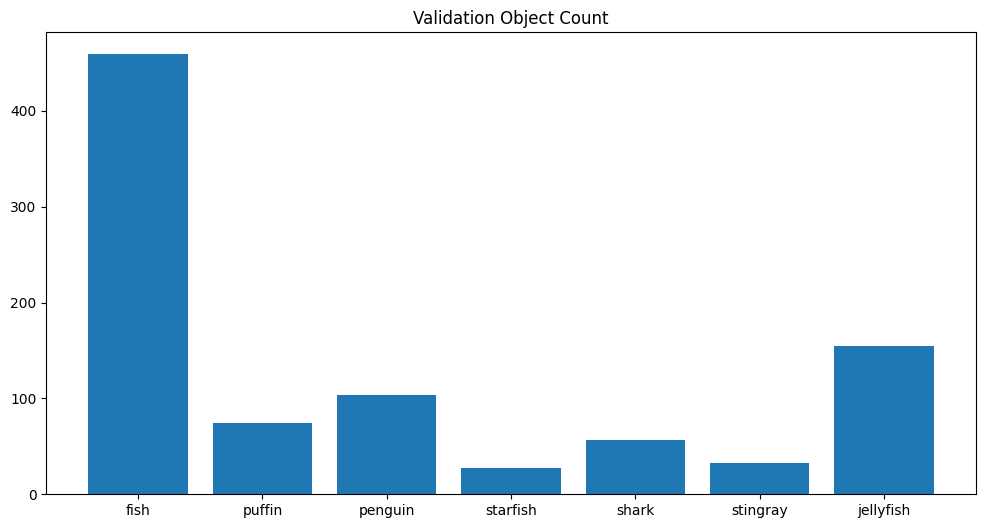

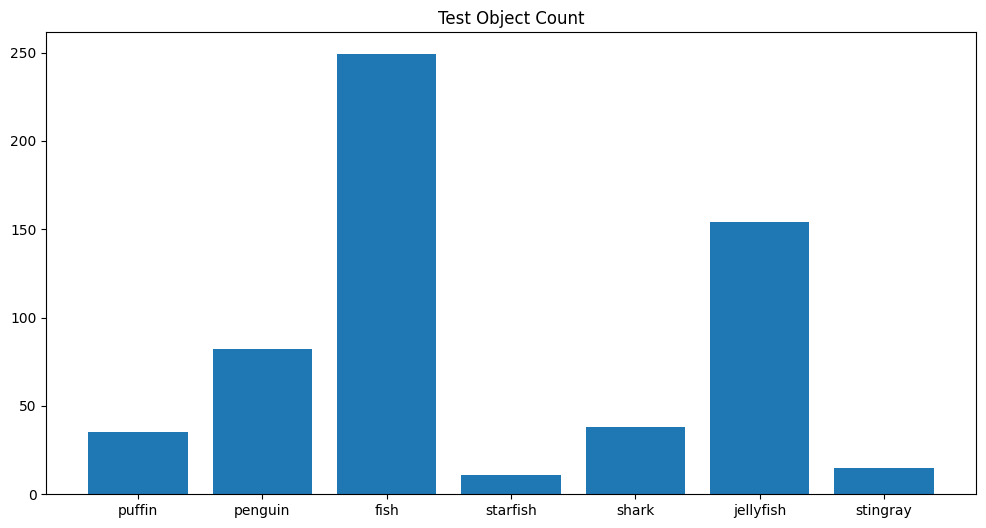

In [19]:
def plot_object_count(object_count, title):
    plt.figure(figsize=(12, 6))
    plt.bar(object_count.keys(), object_count.values())
    plt.title(title)
    plt.show()
    
plot_object_count(train_object_count, "Train Object Count")
plot_object_count(val_object_count, "Validation Object Count")
plot_object_count(test_object_count, "Test Object Count")

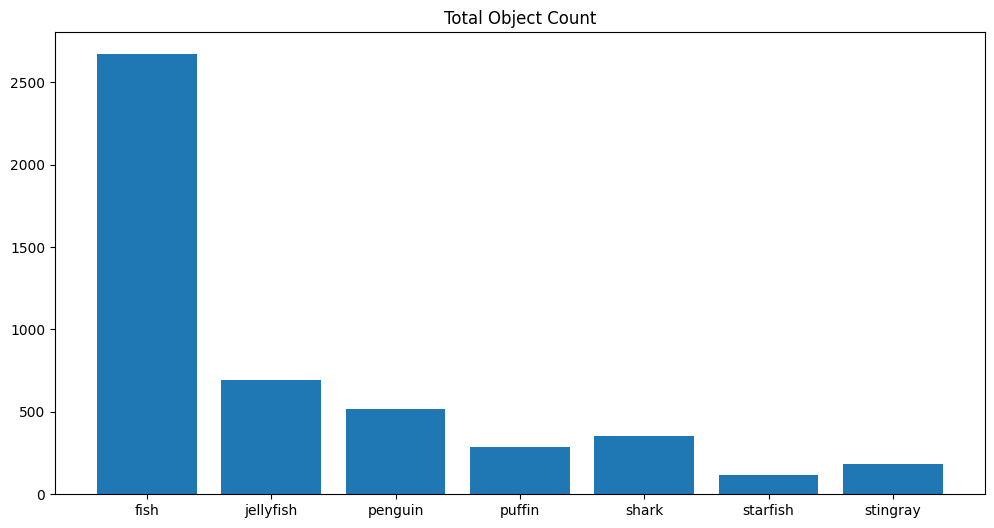

In [20]:
total_object_count = {label: train_object_count.get(label, 0) + val_object_count.get(label, 0) + test_object_count.get(label, 0) for label in classes}
plot_object_count(total_object_count, "Total Object Count")

Number of classes in the datasets are shown, as can be seen fishes are the most common class in the dataset, followed by jellyfish and penguins. This imbalance in the dataset can affect the performance of the model, so we will use techniques like data augmentation and OHEM to address this issue.

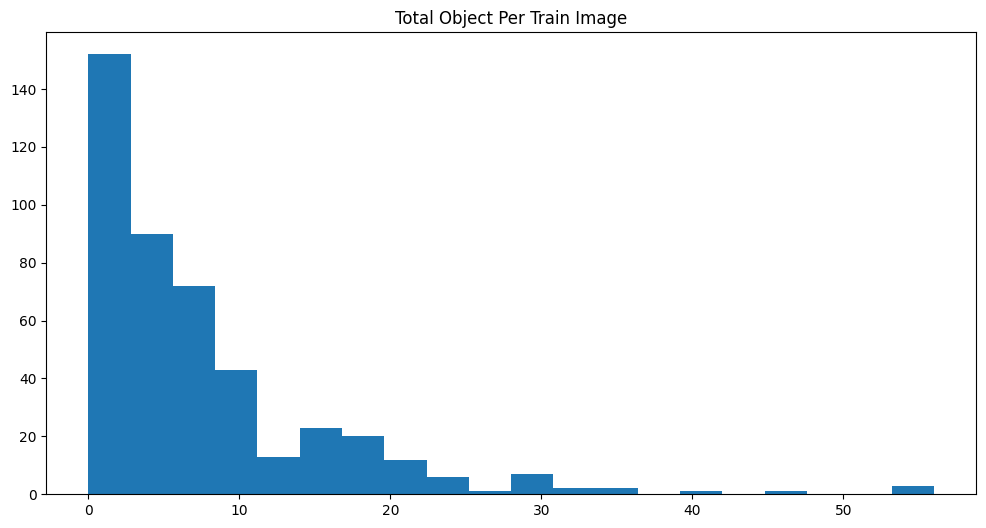

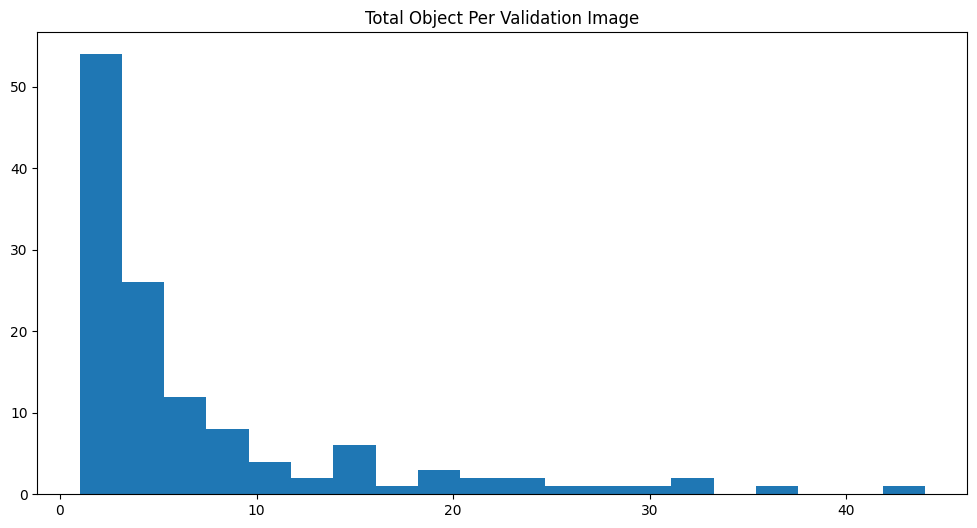

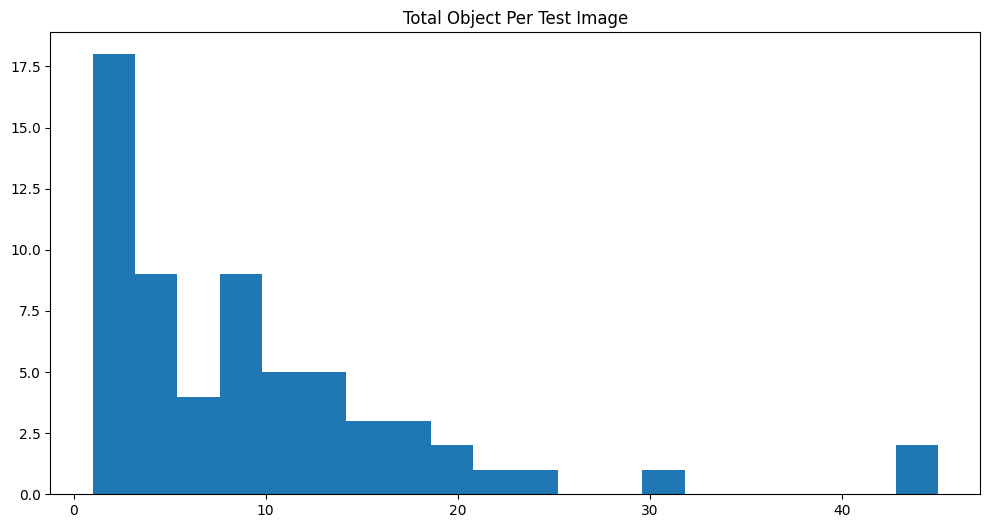

In [21]:
def plot_total_object_per_image(total_object_per_image, title):
    plt.figure(figsize=(12, 6))
    plt.hist(total_object_per_image, bins=20)
    plt.title(title)
    plt.show()
    
plot_total_object_per_image(total_object_per_train_count, "Total Object Per Train Image")
plot_total_object_per_image(total_object_per_val_count, "Total Object Per Validation Image")
plot_total_object_per_image(total_object_per_test_count, "Total Object Per Test Image")

The number of objects per image in all the datasets is shown, as can be seen most of the images contain 1-2 objects. All datasets have a similar distribution of objects per image, so we can use the same techniques for all datasets.

In [22]:
def get_bbox_sizes(image_dir, label_dir, sizes):
    image_files = sorted(os.listdir(image_dir))
    for image_file in tqdm.tqdm(image_files):
        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        for line in lines:
            sizes.append(float(line.split()[3]) * float(line.split()[4]))
        f.close()
        
train_sizes = []
val_sizes = []
test_sizes = []

get_bbox_sizes(TRAIN_IMAGES, TRAIN_LABELS, train_sizes)
get_bbox_sizes(VAL_IMAGES, VAL_LABELS, val_sizes)
get_bbox_sizes(TEST_IMAGES, TEST_LABELS, test_sizes)

100%|██████████| 63/63 [00:00<00:00, 16365.73it/s]


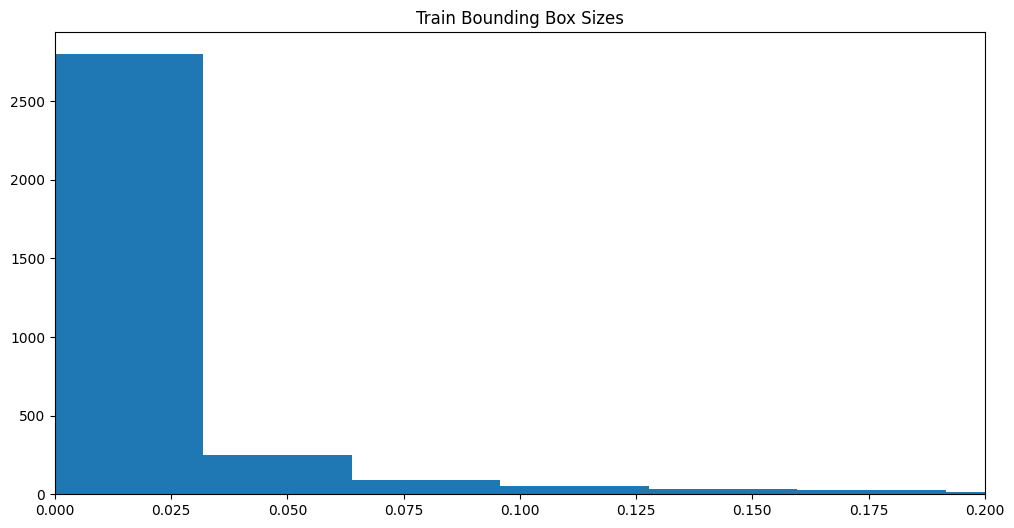

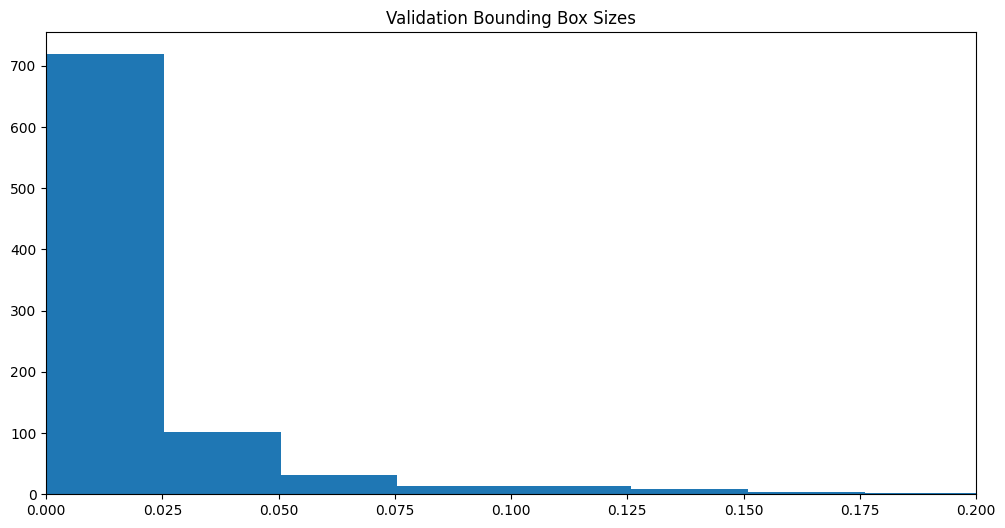

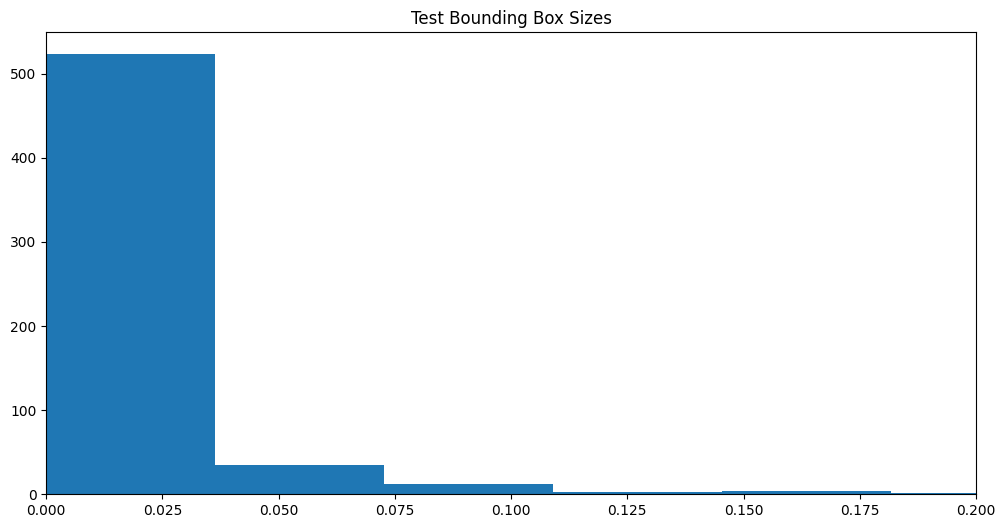

In [23]:
def plot_bbox_sizes(sizes, title):
    plt.figure(figsize=(12, 6))
    plt.hist(sizes, bins=20)
    plt.title(title)
    plt.xlim(0, .2)
    plt.show()
    
plot_bbox_sizes(train_sizes, "Train Bounding Box Sizes")
plot_bbox_sizes(val_sizes, "Validation Bounding Box Sizes")
plot_bbox_sizes(test_sizes, "Test Bounding Box Sizes")

The distribution of bounding box sizes in the datasets is shown. It can help us understand the scale of the objects in the images and choose an appropriate anchor size for the model. It can also be really helpful for our anchor generation.

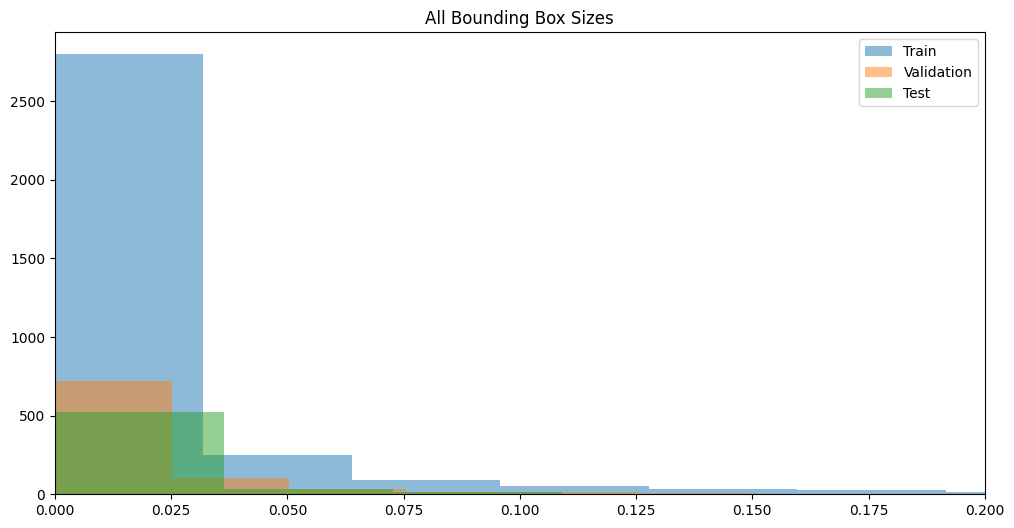

In [24]:
def plot_all_bbox_sizes(train_sizes, val_sizes, test_sizes, title):
    plt.figure(figsize=(12, 6))
    plt.hist(train_sizes, bins=20, alpha=0.5, label="Train")
    plt.hist(val_sizes, bins=20, alpha=0.5, label="Validation")
    plt.hist(test_sizes, bins=20, alpha=0.5, label="Test")
    plt.title(title)
    plt.xlim(0, .2)
    plt.legend()
    plt.show()
    
plot_all_bbox_sizes(train_sizes, val_sizes, test_sizes, "All Bounding Box Sizes")

In [25]:
def count_width_height(image_dir, label_dir, width_height):
    image_files = sorted(os.listdir(image_dir))
    for image_file in tqdm.tqdm(image_files):
        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        for line in lines:
            width_height.append((float(line.split()[3]), float(line.split()[4])))
        f.close()
        
train_width_height = []
val_width_height = []
test_width_height = []

count_width_height(TRAIN_IMAGES, TRAIN_LABELS, train_width_height)
count_width_height(VAL_IMAGES, VAL_LABELS, val_width_height)
count_width_height(TEST_IMAGES, TEST_LABELS, test_width_height)

100%|██████████| 63/63 [00:00<00:00, 15663.38it/s]


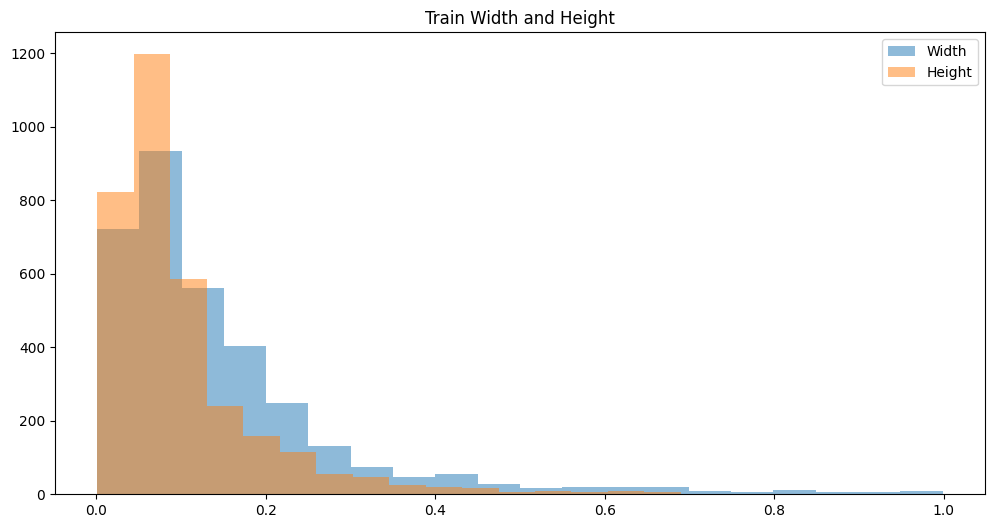

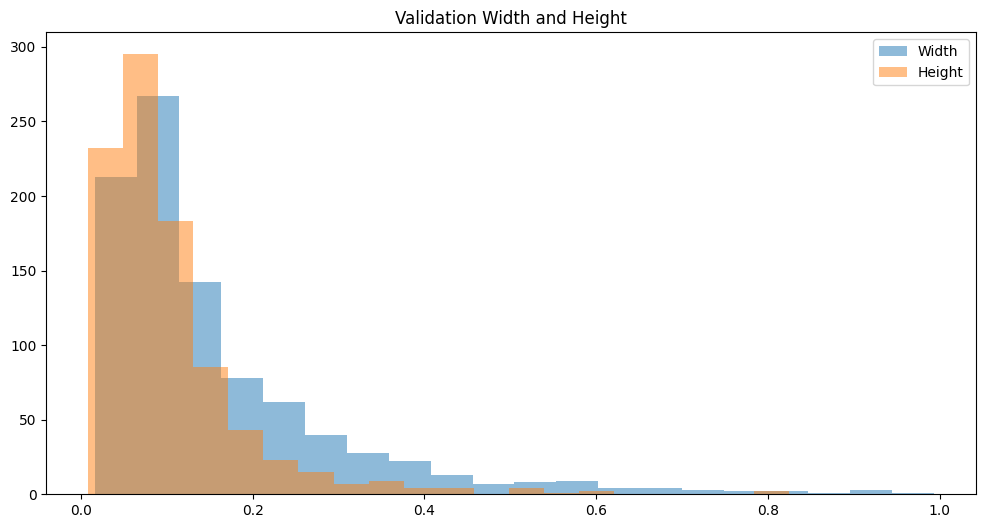

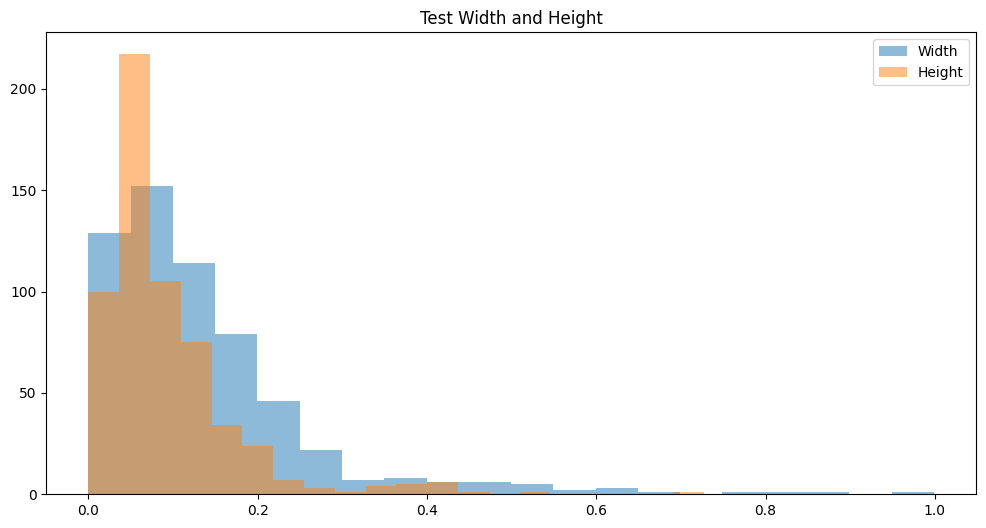

In [26]:
def plot_width_height(width_height, title):
    width, height = zip(*width_height)
    plt.figure(figsize=(12, 6))
    plt.hist(width, bins=20, alpha=0.5, label="Width")
    plt.hist(height, bins=20, alpha=0.5, label="Height")
    plt.title(title)
    plt.legend()
    plt.show()
    
plot_width_height(train_width_height, "Train Width and Height")
plot_width_height(val_width_height, "Validation Width and Height")
plot_width_height(test_width_height, "Test Width and Height")

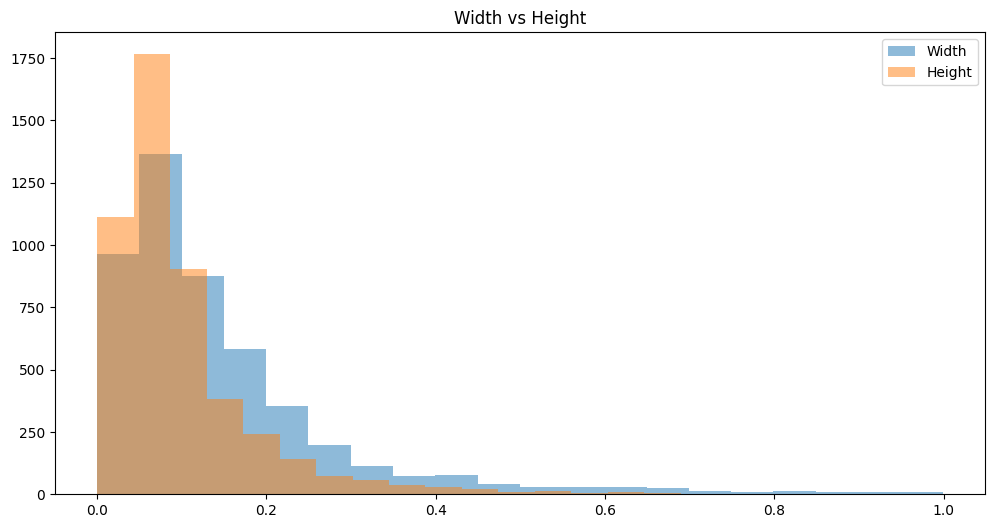

In [27]:
total_width_height = train_width_height + val_width_height + test_width_height
plot_width_height(total_width_height, "Width vs Height")

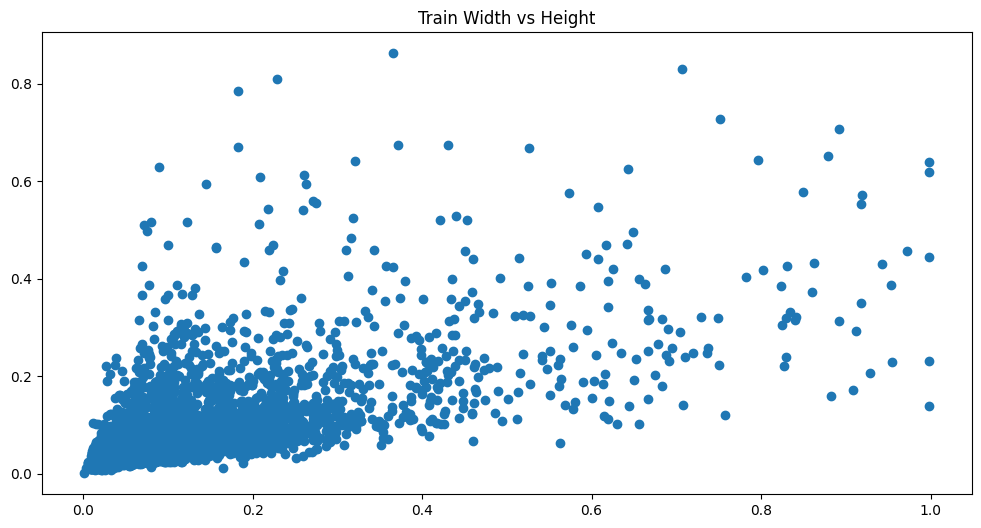

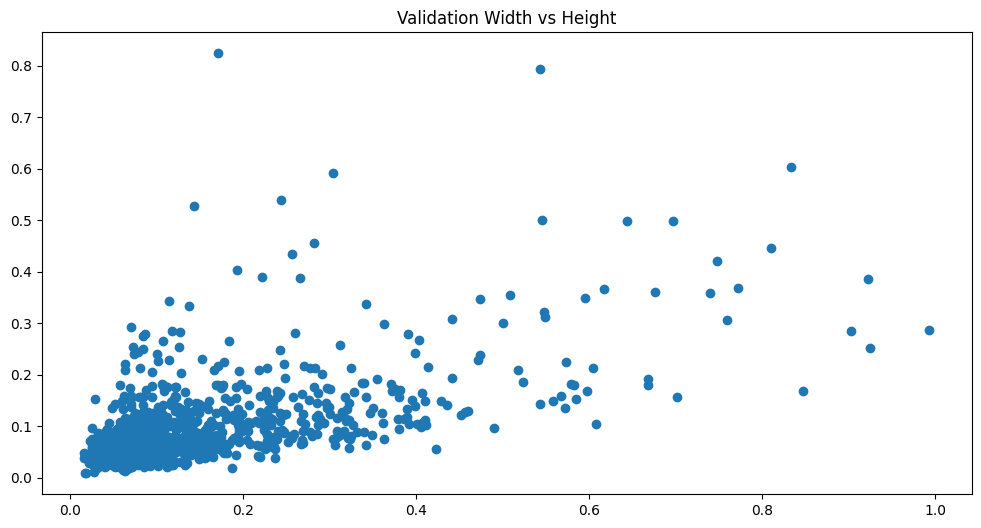

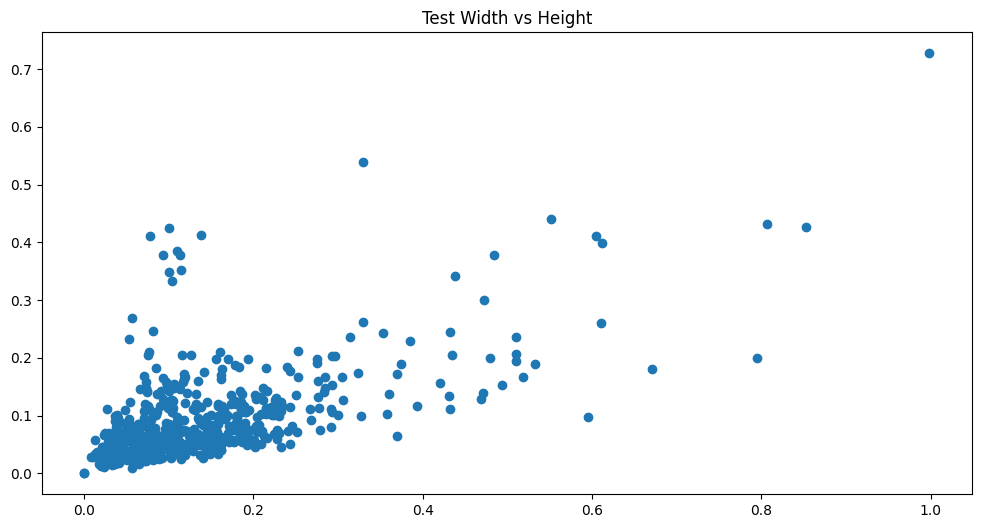

In [28]:
def plot_width_height_scatter(width_height, title):
    width, height = zip(*width_height)
    plt.figure(figsize=(12, 6))
    plt.scatter(width, height)
    plt.title(title)
    plt.show()
    
plot_width_height_scatter(train_width_height, "Train Width vs Height")
plot_width_height_scatter(val_width_height, "Validation Width vs Height")
plot_width_height_scatter(test_width_height, "Test Width vs Height")

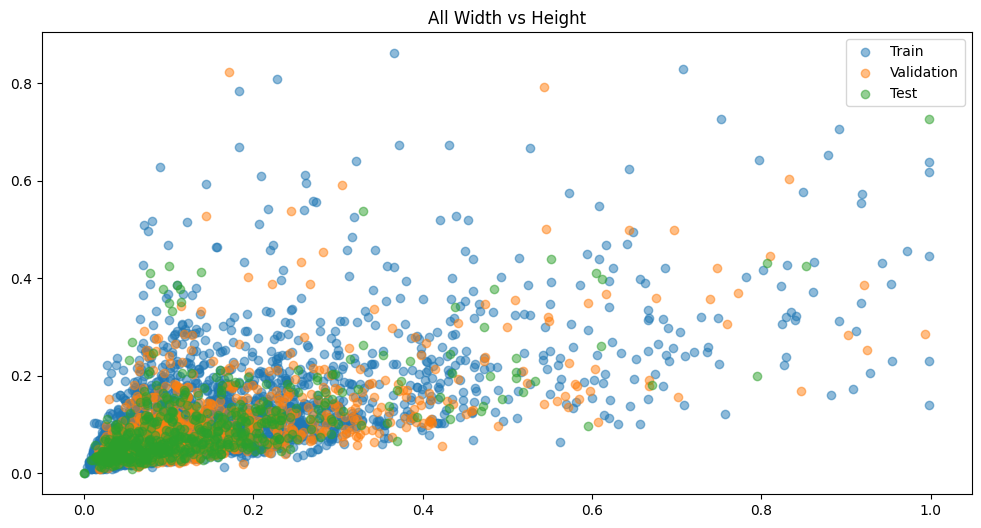

In [29]:
def plot_all_width_height_scatter(train_width_height, val_width_height, test_width_height, title):
    train_width, train_height = zip(*train_width_height)
    val_width, val_height = zip(*val_width_height)
    test_width, test_height = zip(*test_width_height)
    plt.figure(figsize=(12, 6))
    plt.scatter(train_width, train_height, alpha=0.5, label="Train")
    plt.scatter(val_width, val_height, alpha=0.5, label="Validation")
    plt.scatter(test_width, test_height, alpha=0.5, label="Test")
    plt.title(title)
    plt.legend()
    plt.show()
    
plot_all_width_height_scatter(train_width_height, val_width_height, test_width_height, "All Width vs Height")

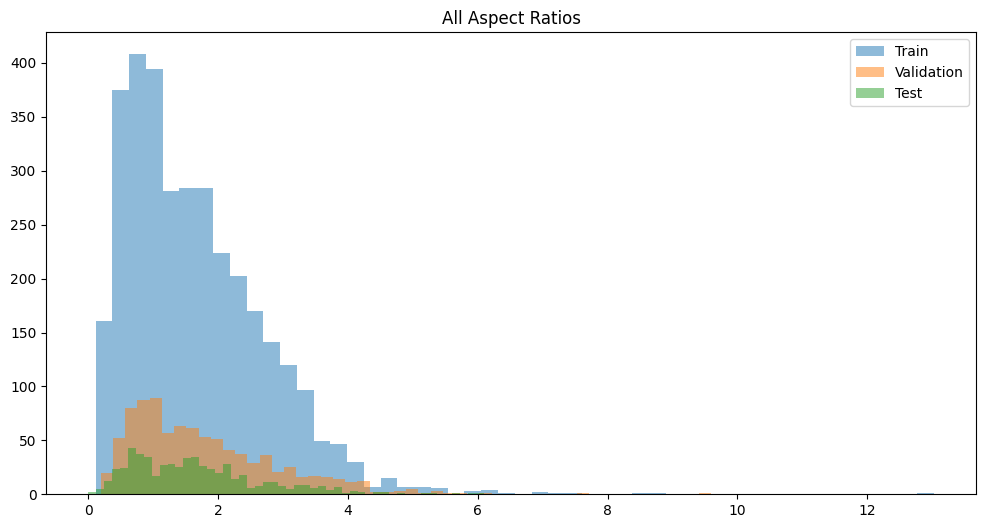

In [30]:
def plot_all_aspect_ratios(train_width_height, val_width_height, test_width_height, title):
    EPSILON = 1e-6
            
    train_aspect_ratio = [w / h if h != 0 else w / (h + EPSILON) for w, h in train_width_height] 
    val_aspect_ratio = [w / h if h != 0 else w / (h + EPSILON) for w, h in val_width_height]
    test_aspect_ratio = [w / h if h != 0 else w / (h + EPSILON) for w, h in test_width_height]
    
    plt.figure(figsize=(12, 6))
    plt.hist(train_aspect_ratio, alpha=0.5, label="Train", bins=50)
    plt.hist(val_aspect_ratio, alpha=0.5, label="Validation", bins=50)
    plt.hist(test_aspect_ratio, alpha=0.5, label="Test", bins=50)
    plt.title(title)
    plt.legend()
    plt.show()

plot_all_aspect_ratios(train_width_height, val_width_height, test_width_height, "All Aspect Ratios")

The width and height of bounding boxes can also help us understand the aspect ratio of the objects in the images and choose an appropriate anchor aspect ratio for the model.

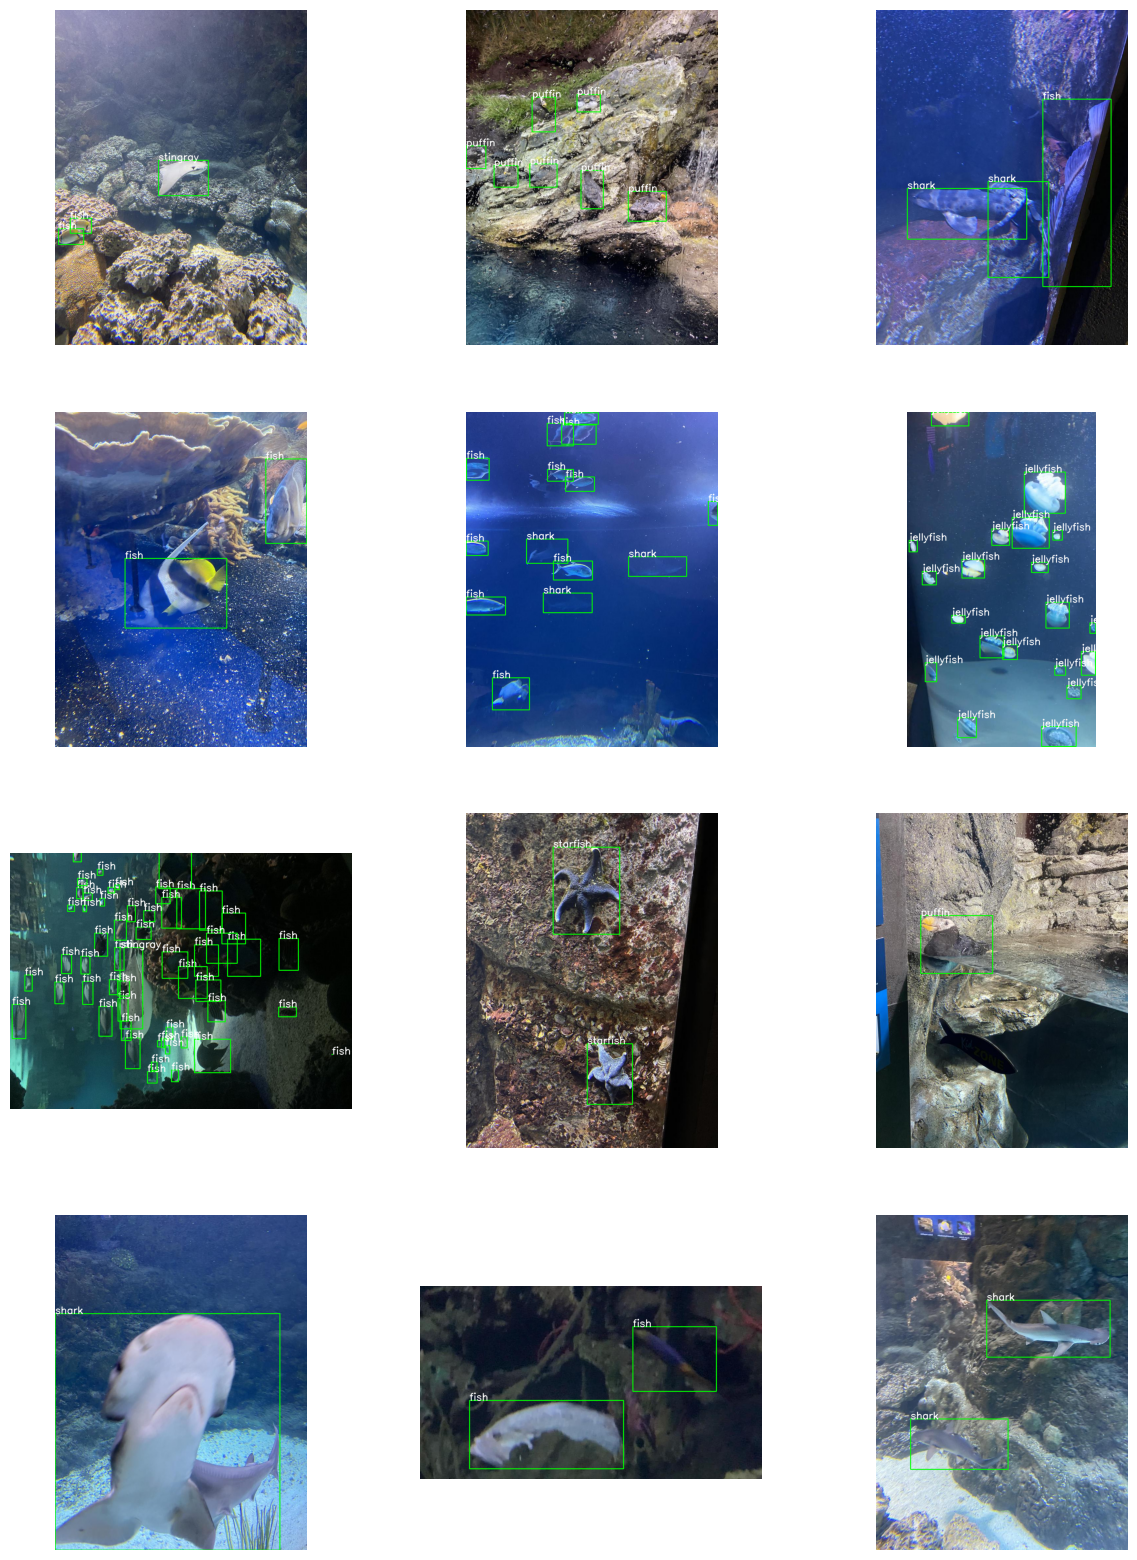

In [31]:
def visualize_image_with_annotation_bounding_boxes(image_dir, label_dir):
    image_files = sorted(os.listdir(image_dir))

    sample_image_files = random.sample(image_files, 12)

    fig, axs = plt.subplots(4, 3, figsize=(15, 20))

    for i, image_file in enumerate(sample_image_files):
        row = i // 3
        col = i % 3

        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")

        for label in f:
            class_id, x_center, y_center, width, height = map(float, label.split())
            h, w, _ = image.shape
            x_min = int((x_center - width / 2) * w)
            y_min = int((y_center - height / 2) * h)
            x_max = int((x_center + width / 2) * w)
            y_max = int((y_center + height / 2) * h)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(
                image,
                Idx2Label[int(class_id)],
                (x_min, y_min),
                cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=1,
                color=(255, 255, 255),
                thickness=2,
            )

        axs[row, col].imshow(image)
        axs[row, col].axis("off")

    plt.show()


visualize_image_with_annotation_bounding_boxes(TRAIN_IMAGES, TRAIN_LABELS)

## Preprocessing

In this step, we will preprocess the dataset by converting the annotations to the format required by the Faster R-CNN model.

### Data Augmentation

For this dataset (images with regions of interest), we will use the following data augmentation techniques:

- **RandomHorizontalFlip**: Randomly flips the image horizontally, here we should be careful to update the labels of objects in the image as well.
- **RandomVerticalFlip**: Randomly flips the image vertically, here we should be careful to update the labels of objects in the image as well.
- **RandomRotation**: Randomly rotates the image by a given angle, here we should be careful to update the labels of objects in the image as well.
- **RandomResizedCrop**: Randomly crops the image to a given size and resizes it to the original size, here we should be careful to update the labels of objects in the image as well.
- **ColorJitter**: Randomly changes the brightness, contrast, saturation, and hue of the image.
- **Mosaic Augmentation**: Mosaic augmentation is a technique that combines four images into one by randomly selecting a center image and placing the other three images around it. This can help the model learn to detect objects in different contexts and improve its performance. Here as well we should be careful to update the labels of objects in the image.

In [29]:
sample_image = random.choice(os.listdir(TRAIN_IMAGES))
image = cv2.imread(os.path.join(TRAIN_IMAGES, sample_image))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

height, width, channels = image.shape
print("The image has dimensions {}x{} and {} channels".format(height, width, channels))

The image has dimensions 768x1024 and 3 channels


In [ ]:
def resize(im, img_size=640, square=False):
    if square:
        im = cv2.resize(im, (img_size, img_size))
    else:
        h0, w0 = im.shape[:2] 
        r = img_size / max(h0, w0) 
        if r != 1:
            im = cv2.resize(im, (int(w0 * r), int(h0 * r)))
    return im

In [ ]:
DESTINATION_PATH = "./aquarium_pretrain"

TRAIN_DESTINATION = DESTINATION_PATH + "/train"
VAL_DESTINATION = DESTINATION_PATH + "/valid"
TEST_DESTINATION = DESTINATION_PATH + "/test"

In [ ]:
def resize_dataset_and_update_labels(image_dir, label_dir, image_dest, label_dest, img_size=640, square=False):
    image_files = sorted(os.listdir(image_dir))
    for image_file in tqdm.tqdm(image_files):
        image_path = os.path.join(image_dir, image_file)
        image = resize(cv2.imread(image_path), img_size, square)
        cv2.imwrite(os.path.join(image_dest, image_file), image)
        
        label_path = os.path.join(label_dir, image_file[:-4] + ".txt")
        f = open(label_path, "r")
        lines = f.readlines()
        f.close()
        
        f = open(os.path.join(label_dest, image_file[:-4] + ".txt"), "w")
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.split())
            x_center *= img_size
            y_center *= img_size
            width *= img_size
            height *= img_size
            f.write("{} {} {} {} {}\n".format(int(class_id), x_center, y_center, width, height))
        f.close()

Resizing is used to resize the images to a fixed size before feeding them to the model. This can help improve the performance of the model and reduce the computational resources required for training.

In [ ]:
def get_train_aug():
    return A.Compose(
        [
            A.OneOf(
                [
                    A.Blur(blur_limit=3, p=0.5),
                    A.MotionBlur(blur_limit=3, p=0.5),
                    A.MedianBlur(blur_limit=3, p=0.5),
                ],
                p=0.5,
            ),
            A.ToGray(p=0.1),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            A.RandomGamma(p=0.1),
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            label_fields=["labels"],
        ),
    )


def get_train_transform():
    return A.Compose(
        [
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            label_fields=["labels"],
        ),
    )

In [ ]:
def get_valid_transform():
    return A.Compose(
        [
            ToTensorV2(p=1.0),
        ],
        bbox_params=A.BboxParams(
            format="pascal_voc",
            label_fields=["labels"],
        ),
    )


def infer_transforms(image):
    transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.ToTensor(),
        ]
    )
    return transform(image)

In [7]:
def preprocess(image_name, image_dir, label_dir):
    image_path = os.path.sep.join([image_dir, image_name])
    name = image_name.split(".")[0]
    label_name = name + ".txt"
    label_path = os.path.sep.join([label_dir, label_name])

    return image_path, label_path, label_name


def draw_rect(img, bboxes, color=(255, 0, 0)):
    img = img.copy()
    height, width = img.shape[:2]
    for bbox in bboxes:
        center_x, center_y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
        x = int((center_x - w / 2) * width)
        w = int(w * width)
        y = int((center_y - h / 2) * height)
        h = int(h * height)
        img = cv2.rectangle(img, (x, y), (x + w, y + h), color, 1)
    return img


def read_img(image_path, cvt_color=True):
    img = cv2.imread(image_path)
    if cvt_color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def save_img(image, save_path, jpg_quality=None):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    if jpg_quality:
        cv2.imwrite(save_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), jpg_quality])
    else:
        cv2.imwrite(save_path, image)


def read_label(label_path):
    with open(label_path) as f:
        conts = f.readlines()

    bboxes = []
    class_labels = []
    for cont in conts:
        cont = cont.strip().split()
        center_x, center_y, w, h = (
            float(cont[1]),
            float(cont[2]),
            float(cont[3]),
            float(cont[4]),
        )
        bboxes.append([center_x, center_y, w, h])
        class_labels.append(cont[0])
    return (bboxes, class_labels)


def display_img(image_path, label_path):
    img = read_img(image_path, cvt_color=False)
    bboxes = read_label(label_path)[0]
    img = draw_rect(img, bboxes)
    cv2.imshow("Image", img)
    cv2.waitKey(0)


def save_label(bboxes, class_labels, label_path):
    tem_lst = []
    for i, bbox in enumerate(bboxes):
        tem_lst.append(
            class_labels[i]
            + " "
            + str(bbox[0])
            + " "
            + str(bbox[1])
            + " "
            + str(bbox[2])
            + " "
            + str(bbox[3])
            + "\n"
        )

    with open(label_path, "w") as f:
        f.writelines(tem_lst)

In [ ]:
def random_crop_savebboxes(
    image_name, image_dir, label_dir, expected_h, expected_w, min_area, min_visibility
):
    image_path, label_path, _ = preprocess(image_name, image_dir, label_dir)

    (bboxes, class_labels) = read_label(label_path)

    transform = A.Compose(
        [A.RandomResizedCrop(expected_h, expected_w)],
        bbox_params=A.BboxParams(
            format="yolo",
            label_fields=["class_labels"],
            min_area=min_area,
            min_visibility=min_visibility,
        ),
    )

    transformed = transform(image=read_img(image_path), bboxes=bboxes, class_labels=class_labels)
    transformed_image = transformed["image"]
    transformed_bboxes = transformed["bboxes"]
    transformed_class_labels = transformed["class_labels"]

    return transformed_image, transformed_bboxes, transformed_class_labels

In [8]:
def mosaic(
    image_file_list,
    image_dir,
    label_dir,
    output_image_dir,
    output_label_dir,
    mo_w,
    mo_h,
    scale_x,
    scale_y,
    min_area,
    min_visibility,
    show_image=False,
):

    new_img = np.zeros((mo_h, mo_w, 3), dtype="uint8")

    div_point_x = int(mo_w * scale_x)
    div_point_y = int(mo_h * scale_y)

    for i in range(len(image_file_list)):
        if i == 0:
            w0 = div_point_x
            h0 = div_point_y
            img_0, bboxes_0, class_labels_0 = random_crop_savebboxes(
                image_file_list[0],
                image_dir,
                label_dir,
                h0,
                w0,
                min_area,
                min_visibility,
            )
            new_img[:div_point_y, :div_point_x, :] = img_0

            if len(bboxes_0) == 0:
                bboxes_0_new = []
            else:
                bboxes_0_new = np.zeros((len(bboxes_0), 4))
                bboxes_0_new = bboxes_0_new.tolist()

            for i, box in enumerate(bboxes_0):
                bboxes_0_new[i][0] = box[0] * scale_x
                bboxes_0_new[i][2] = box[2] * scale_x

                bboxes_0_new[i][1] = box[1] * scale_y
                bboxes_0_new[i][3] = box[3] * scale_y

        elif i == 1:
            w1 = mo_w - div_point_x
            h1 = div_point_y
            img_1, bboxes_1, class_labels_1 = random_crop_savebboxes(
                image_file_list[1],
                image_dir,
                label_dir,
                h1,
                w1,
                min_area,
                min_visibility,
            )
            new_img[:div_point_y, div_point_x:, :] = img_1

            if len(bboxes_1) == 0:
                bboxes_1_new = []
            else:
                bboxes_1_new = np.zeros((len(bboxes_1), 4))
                bboxes_1_new = bboxes_1_new.tolist()

            for i, box in enumerate(bboxes_1):
                bboxes_1_new[i][0] = box[0] * (1 - scale_x) + scale_x
                bboxes_1_new[i][2] = box[2] * (1 - scale_x)

                bboxes_1_new[i][1] = box[1] * scale_y
                bboxes_1_new[i][3] = box[3] * scale_y

        elif i == 2:
            w2 = div_point_x
            h2 = mo_h - div_point_y
            img_2, bboxes_2, class_labels_2 = random_crop_savebboxes(
                image_file_list[2],
                image_dir,
                label_dir,
                h2,
                w2,
                min_area,
                min_visibility,
            )
            new_img[div_point_y:, :div_point_x, :] = img_2

            if len(bboxes_2) == 0:
                bboxes_2_new = []
            else:
                bboxes_2_new = np.zeros((len(bboxes_2), 4))
                bboxes_2_new = bboxes_2_new.tolist()

            for i, box in enumerate(bboxes_2):
                bboxes_2_new[i][0] = box[0] * scale_x
                bboxes_2_new[i][2] = box[2] * scale_x

                bboxes_2_new[i][1] = box[1] * (1 - scale_y) + scale_y
                bboxes_2_new[i][3] = box[3] * (1 - scale_y)

        else:
            w3 = mo_w - div_point_x
            h3 = mo_h - div_point_y
            img_3, bboxes_3, class_labels_3 = random_crop_savebboxes(
                image_file_list[3],
                image_dir,
                label_dir,
                h3,
                w3,
                min_area,
                min_visibility,
            )
            new_img[div_point_y:, div_point_x:, :] = img_3

            if len(bboxes_3) == 0:
                bboxes_3_new = []
            else:
                bboxes_3_new = np.zeros((len(bboxes_3), 4))
                bboxes_3_new = bboxes_3_new.tolist()

            for i, box in enumerate(bboxes_3):
                bboxes_3_new[i][0] = box[0] * (1 - scale_x) + scale_x 
                bboxes_3_new[i][2] = box[2] * (1 - scale_x)

                bboxes_3_new[i][1] = box[1] * (1 - scale_y) + scale_y 
                bboxes_3_new[i][3] = box[3] * (1 - scale_y)

    new_class_labels = class_labels_0 + class_labels_1 + class_labels_2 + class_labels_3
    new_bboxes = bboxes_0_new + bboxes_1_new + bboxes_2_new + bboxes_3_new

    image_store_path = os.path.sep.join(
        [
            output_image_dir,
            "mo_"
            + image_file_list[0].split(".")[0]
            + "_"
            + image_file_list[1].split(".")[0]
            + "_"
            + image_file_list[2].split(".")[0]
            + "_"
            + image_file_list[3].split(".")[0]
            + ".jpg",
        ]
    )
    label_store_path = os.path.sep.join(
        [
            output_label_dir,
            "mo_"
            + image_file_list[0].split(".")[0]
            + "_"
            + image_file_list[1].split(".")[0]
            + "_"
            + image_file_list[2].split(".")[0]
            + "_"
            + image_file_list[3].split(".")[0]
            + ".txt",
        ]
    )

    save_img(new_img, image_store_path)
    save_label(new_bboxes, new_class_labels, label_store_path)
    
    if show_image:
        cv2.imshow("Mosaic Image", new_img)
        cv2.waitKey(0)

In [ ]:
def convert_detections(outputs, detection_threshold, classes, args):
    boxes = outputs[0]["boxes"].data.numpy()
    scores = outputs[0]["scores"].data.numpy()

    if args["classes"] is not None:
        labels = outputs[0]["labels"].cpu().numpy()
        lbl_mask = np.isin(labels, args["classes"])
        scores = scores[lbl_mask]
        mask = scores > detection_threshold
        draw_boxes = boxes[lbl_mask][mask]
        scores = scores[mask]
        labels = labels[lbl_mask][mask]
        pred_classes = [classes[i] for i in labels]
    else:
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        pred_classes = [classes[i] for i in outputs[0]["labels"].cpu().numpy()]

    return draw_boxes, pred_classes, scores


def convert_pre_track(draw_boxes, pred_classes, scores):
    final_preds = []
    for i, box in enumerate(draw_boxes):
        final_preds.append(
            (
                [box[0], box[1], box[2] - box[0], box[3] - box[1]],
                scores[i],
                str(pred_classes[i]),
            )
        )
    return final_preds


def convert_post_track(tracks):
    draw_boxes, pred_classes, scores, track_id = [], [], [], []
    for track in tracks:
        if not track.is_confirmed():
            continue
        score = track.det_conf
        if score is None:
            continue
        track_id = track.track_id
        pred_class = track.det_class
        pred_classes.append(f"{track_id} {pred_class}")
        scores.append(score)
        draw_boxes.append(track.to_ltrb())
    return draw_boxes, pred_classes, scores


def inference_annotations(
    draw_boxes, pred_classes, scores, classes, colors, orig_image, image, args
):
    height, width, _ = orig_image.shape
    lw = max(round(sum(orig_image.shape) / 2 * 0.003), 2)
    tf = max(lw - 1, 1)

    for j, box in enumerate(draw_boxes):
        p1 = (
            int(box[0] / image.shape[1] * width),
            int(box[1] / image.shape[0] * height),
        )
        p2 = (
            int(box[2] / image.shape[1] * width),
            int(box[3] / image.shape[0] * height),
        )
        class_name = pred_classes[j]
        if args["track"]:
            color = colors[classes.index(" ".join(class_name.split(" ")[1:]))]
        else:
            color = colors[classes.index(class_name)]
        cv2.rectangle(
            orig_image, p1, p2, color=color, thickness=lw, lineType=cv2.LINE_AA
        )
        if not args["no_labels"]:
            final_label = class_name + " " + str(round(scores[j], 2))
            w, h = cv2.getTextSize(
                final_label, cv2.FONT_HERSHEY_SIMPLEX, fontScale=lw / 3, thickness=tf
            )[0]
            w = int(w - (0.20 * w))
            outside = p1[1] - h >= 3
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(
                orig_image, p1, p2, color=color, thickness=-1, lineType=cv2.LINE_AA
            )
            cv2.putText(
                orig_image,
                final_label,
                (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=lw / 3.8,
                color=(255, 255, 255),
                thickness=tf,
                lineType=cv2.LINE_AA,
            )
    return orig_image


def draw_text(
    img,
    text,
    font=cv2.FONT_HERSHEY_SIMPLEX,
    pos=(0, 0),
    font_scale=1,
    font_thickness=2,
    text_color=(0, 255, 0),
    text_color_bg=(0, 0, 0),
):
    offset = (5, 5)
    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    rec_start = tuple(x - y for x, y in zip(pos, offset))
    rec_end = tuple(x + y for x, y in zip((x + text_w, y + text_h), offset))
    cv2.rectangle(img, rec_start, rec_end, text_color_bg, -1)
    cv2.putText(
        img,
        text,
        (x, int(y + text_h + font_scale - 1)),
        font,
        font_scale,
        text_color,
        font_thickness,
        cv2.LINE_AA,
    )
    return img


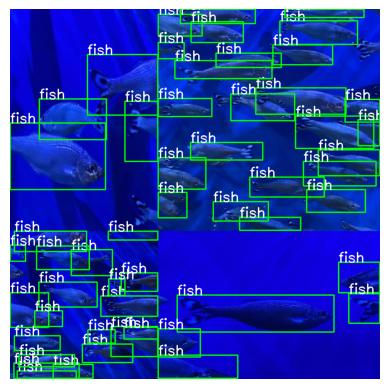

In [35]:
mosaic(
    ["274.jpg", "275.jpg", "276.jpg", "280.jpg"],
    TRAIN_IMAGES,
    TRAIN_LABELS,
    TRAIN_DESTINATION,
    TRAIN_LABELS,
    640,
    640,
    0.5,
    0.5,
    0.1,
    0.3,
    show_image=True,
)

### DataLoader

We will create a custom dataset class to load the images and annotations from the dataset and apply the data augmentation techniques. We will also create a data loader to load the data in batches and shuffle it during training.

In [ ]:
class CustomDataset(Dataset):
    def __init__(
        self,
        images_path,
        labels_path,
        img_size,
        classes,
        transforms=None,
        use_train_aug=False,
        train=False,
        mosaic=1.0,
        square_training=False,
    ):
        self.transforms = transforms
        self.use_train_aug = use_train_aug
        self.images_path = images_path
        self.labels_path = labels_path
        self.img_size = img_size
        self.classes = classes
        self.train = train
        self.square_training = square_training
        self.mosaic_border = [-img_size // 2, -img_size // 2]
        self.all_image_paths = []
        self.log_annot_issue_x = True
        self.mosaic = mosaic
        self.log_annot_issue_y = True

        for file_type in self.image_file_types:
            self.all_image_paths.extend(
                glob.glob(os.path.join(self.images_path, file_type))
            )
        self.all_images = [
            image_path.split(os.path.sep)[-1] for image_path in ["*.jpg", "*.jpeg"]
        ]
        self.all_images = sorted(self.all_images)
        
        self.all_labels = [
            label_path.split(os.path.sep)[-1] for label_path in glob.glob(os.path.join(self.labels_path, "*.txt"))
        ]

    def __getitem__(self, idx):
        image = self.all_images[idx]
        label = self.all_labels[idx]
        return image, label

    def __len__(self):
        return len(self.all_images)


def collate_fn(batch):
    """
    To handle the data loading as different images may have different number
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [ ]:
def create_train_dataset(
    train_dir_images,
    train_dir_labels,
    img_size,
    classes,
    use_train_aug=False,
    mosaic=1.0,
    square_training=False,
):
    train_dataset = CustomDataset(
        train_dir_images,
        train_dir_labels,
        img_size,
        classes,
        get_train_transform(),
        use_train_aug=use_train_aug,
        train=True,
        mosaic=mosaic,
        square_training=square_training,
    )
    return train_dataset


def create_valid_dataset(valid_dir_images, valid_dir_labels, img_size, classes, square_training=False):
    valid_dataset = CustomDataset(
        valid_dir_images,
        valid_dir_labels,
        img_size,
        classes,
        get_valid_transform(),
        train=False,
        square_training=square_training,
    )
    return valid_dataset


def create_train_loader(train_dataset, batch_size, num_workers=0, batch_sampler=None):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        sampler=batch_sampler,
        collate_fn=collate_fn,
    )
    return train_loader


def create_valid_loader(valid_dataset, batch_size, num_workers=0, batch_sampler=None):
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        sampler=batch_sampler,
        collate_fn=collate_fn,
    )
    return valid_loader

In [ ]:
train_dataset = create_train_dataset(
    TRAIN_IMAGES,
    TRAIN_LABELS,
    (640, 640),
    classes,
    use_train_aug=True,
    mosaic=1.0,
)

valid_dataset = create_valid_dataset(
    VAL_IMAGES,
    VAL_LABELS,
    (640, 640),
    classes,
)
    
train_sampler = RandomSampler(train_dataset)
valid_sampler = SequentialSampler(valid_dataset)

train_loader = create_train_loader(train_dataset, batch_size=2, num_workers=2, batch_sampler=train_sampler)
valid_loader = create_valid_loader(valid_dataset, batch_size=2, num_workers=2, batch_sampler=valid_sampler)